In [24]:
# Required Python Libraries

# Google Colab file importing
from google.colab import files

# basic data manipulation
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# scikit-learn model evauluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# XGBoost model
from xgboost import XGBClassifier

# Imbalanced-Learn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

In [3]:
def encode_ordinal_nominal(df, ordinal_variables=None):
  """
  Encodes categorical variables in a pandas DataFrame using one-hot encoding.

  Args:
    df: A pandas DataFrame containing categorical variables.
    ordinal_variables: A dictionary mapping categorical variables to their ordinal values.

  Returns:
    A new pandas DataFrame with the categorical variables encoded using one-hot encoding and ordinal encoding if provided.
  """
  # make a copy of the original DF to ensure data integrity
  encoded_df = df.copy()

  # empty if no orderinal variables passed
  ordinal_variables = ordinal_variables or {}

  # filtering for categorical date type columns (object or category)
  categorical_columns = df.select_dtypes(include=['object', 'category']).columns

  # separate nominal and ordinal columns
  ordinal_columns = list(ordinal_variables.keys())
  nominal_columns = [col for col in categorical_columns if col not in ordinal_columns]

  # apply one-hot encoding if nominal variables exist
  if nominal_columns:
        encoded_df = pd.get_dummies(encoded_df, columns=nominal_columns, drop_first=True)

  # apply ordinal encoding if ordinal variables exist
  if ordinal_columns:
        # all ordinal columns exist in the DataFrame
        valid_ordinal_columns = [col for col in ordinal_columns if col in encoded_df.columns]
        if valid_ordinal_columns:
            # get category orders for ordinal columns
            ordinal_categories = [ordinal_variables[col] for col in valid_ordinal_columns]
            # initialize OrdinalEncoder with category orders
            encoder = OrdinalEncoder(categories=ordinal_categories, dtype=int)
            # apply encoding to ordinal columns
            encoded_df[valid_ordinal_columns] = encoder.fit_transform(encoded_df[valid_ordinal_columns])

  return encoded_df

In [4]:
def convert_to_binary(df, target_column):
  """
  Converts a categorical target variable in a pandas DataFrame to binary values.

  Args:
    df: A pandas DataFrame containing the target variable.
    target_column: The name of the column to be converted.

  Returns:
    A new pandas DataFrame with the target variable converted to binary values.

  Raises:
    ValueError: If column contains values other than 1 or 2
    ValueError: If target column not found in DataFrame
  """
  # check target column exists
  if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in DataFrame.")

  # validate target variable 1 or 2
  if not df[target_column].isin([1, 2]).all():
    raise ValueError(f"Target column '{target_column}' contains values other than 1 or 2.")

  # convert target variable to binary with map
  df[target_column] = df[target_column].map({1: 0, 2: 1})

  return df

In [5]:
def split_data(df, target_column):
  """
  Splits a pandas DataFrame into a feature set and a target variable.

  Args:
    df: A pandas DataFrame containing the data to be split.
    target_column: The name of the column to be used as the target variable.

  Returns:
    tuple (x,y) containing DF of features and series of target variable.
  """
  # check target column exists
  if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in DataFrame.")

  # drop target column to make features dataframe
  x = df.drop(target_column, axis=1)

  # create target series
  y = df[target_column]

  return x, y

In [6]:
def apply_smote(x_train, y_train):
  """
  Applies SMOTE to the training data.

  Args:
    x_train: A pandas DataFrame containing the training features.
    y_train: A pandas Series containing the target variable for the training data.

  Returns:
    tuple (x_train_resampled, y_train_resampled) containing the resampled training data.
  """
  # initialize SMOTE
  adasyn = ADASYN(random_state=42)

  # apply SMOTE to the training data
  x_train_resampled, y_train_resampled = adasyn.fit_resample(x_train, y_train)

  return x_train_resampled, y_train_resampled

In [7]:
def preprocess_split(df, target_column, scaler_method=1, test_size=0.2, train_size=0.8, random_state=42):
  """
  Preprocesses the data encoding categorical/scaling numeric features and splits it into training and testing sets.

  Args:
    df: A pandas DataFrame containing the data to be preprocessed and split.
    target_column: The name of the column to be used as the target variable.
    scaler: The scaler to be used for scaling the numeric features.
    test_size: The proportion of the data to include in the test split.
    train_size: The proportion of the data to include in the train split.
    random_state: The seed used by the random number generator.

  Returns:
  tuple (x_train, x_test, y_train, y_test)
  """
  # numerical columns (exclude target) filtered for scaling post split
  numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
  numerical_columns = [col for col in numerical_columns if col != target_column]

  # process categorical variables as nominal or ordinal
  df = encode_ordinal_nominal(df)

  # convert target variable to binary
  df = convert_to_binary(df, target_column)

  # split features and target data
  x, y = split_data(df, target_column)

  # split training and test sets for features and targets
  # use sklearn train_test_split library
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, train_size=train_size, random_state=random_state, stratify= y)

  if scaler_method == 1:
    scaler = StandardScaler()
  elif scaler_method == 2:
    scaler = MinMaxScaler()

  # apply scaler to numerical columns if they exist
  if numerical_columns:
      # Fit and transform on training data
      x_train[numerical_columns] = scaler.fit_transform(x_train[numerical_columns])
      # Transform test data using the same scaler
      x_test[numerical_columns] = scaler.transform(x_test[numerical_columns])

  # apply SMOTE to balance the training set
  x_train, y_train = apply_smote(x_train, y_train)

  return x_train, x_test, y_train, y_test

In [8]:
def log_reg_pred(x_train, x_test, y_train):
  """
  Trains a logistic regression model on the training data and makes predictions on the test data.

  Args:
    x_train: A pandas DataFrame containing the training features.
    x_test: A pandas DataFrame containing the test features.
    y_train: A pandas Series containing the target variable for the training data.

  Returns:
    2x pandas Series - first containing the predicted target variable values for the test data second the prediction probabilities.
  """
  # initialize the logistic model
  log_reg = LogisticRegression()

  # train the logistic model
  log_reg.fit(x_train, y_train)

  # make predictions on the test set
  y_pred = log_reg.predict(x_test)

  # prediction probability for ROC AUC
  y_pred_prob = log_reg.predict_proba(x_test)[:, 1]

  return y_pred, y_pred_prob

In [9]:
def decision_tree_pred(x_train, x_test, y_train):
  """
  Trains a decision tree model on the training data and makes predictions on the test data.

  Args:
    x_train: A pandas DataFrame containing the training
    x_test: A pandas DataFrame containing the test features.
    y_train: A pandas Series containing the target variable for the training data.

  Returns:
    2x pandas Series - first containing the predicted target variable values for the test data second the prediction probabilities.
  """

  # initialize the decision tree model
  decision_tree = DecisionTreeClassifier()

  # train the decision tree model
  decision_tree.fit(x_train, y_train)

  # make predictions on the test set
  y_pred = decision_tree.predict(x_test)

  # prediction probability for ROC AUC
  y_pred_prob = decision_tree.predict_proba(x_test)[:, 1]

  return y_pred, y_pred_prob

In [10]:
def knn_pred(x_train, x_test, y_train):
  """
  Trains a K-nearest neighbors model on the training data and makes predictions on the test data.

  Args:
    x_train: A pandas DataFrame containing the training features.
    x_test: A pandas DataFrame containing the test features.
    y_train: A pandas Series containing the target variable for the training data.

  Returns:
    2x pandas Series - first containing the predicted target variable values for the test data second the prediction probabilities.
  """
  # initialize the KNN model
  knn = KNeighborsClassifier()

  # train the KNN model
  knn.fit(x_train, y_train)

  # make predictions on the test set
  y_pred = knn.predict(x_test)

  # prediction probability for ROC AUC
  y_pred_prob = knn.predict_proba(x_test)[:, 1]

  return y_pred, y_pred_prob

In [11]:
def svm_pred(x_train, x_test, y_train):
  """
  Trains a Support Vector Machine (SVM) model on the training data and makes predictions on the test data.

  Args:
    x_train: A pandas DataFrame containing the training features.
    x_test: A pandas DataFrame containing the test features.
    y_train: A pandas Series containing the target variable for the training data.

  Returns:
    2x pandas Series - first containing the predicted target variable values for the test data second the prediction probabilities.
  """
  # initialize the SVM model
  svm = SVC()

  # train the SVM model
  svm.fit(x_train, y_train)

  # make predictions on the test set
  y_pred = svm.predict(x_test)

  # prediction probability for ROC AUC
  y_pred_prob = svm.decision_function(x_test)

  return y_pred, y_pred_prob

In [12]:
def xgboost_pred(x_train, x_test, y_train):
  """
  Trains an XGBoost model on the training data and makes predictions on the test data.

  Args:
    x_train: A pandas DataFrame containing the training features.
    x_test: A pandas DataFrame containing the test features.
    y_train: A pandas Series containing the target variable for the training data.

  Returns:
    2x pandas Series - first containing the predicted target variable values for the test data second the prediction probabilities.
  """
  # initialize the XGBoost model
  xgboost = XGBClassifier()

  # train the XGBoost model
  xgboost.fit(x_train, y_train)

  # make predictions on the test set
  y_pred = xgboost.predict(x_test)

  # prediction probability for ROC AUC
  y_pred_prob = xgboost.predict_proba(x_test)[:, 1]

  return y_pred, y_pred_prob

In [13]:
def plot_cm(df, target_column, model_funcs, scaler_method=1):
  """
  Plot confusion matrix for dataset using models listed in model_funcs

  Args:
    df: A pandas DataFrame containing the data to be preprocessed and split.
    target_column: The name of the column to be used as the target variable.
    scaler: The scaler to be used for scaling the numeric features.
    model_funcs: A list of tuples containing the name and function for each model.

  Returns:
    None
  """
  # preprocess the data and split for train-test sets
  x_train, x_test, y_train, y_test = preprocess_split(df, target_column, scaler_method)

  for model_name, model_func in model_funcs:
    # model predictions
    y_pred, y_pred_prob = model_func(x_train, x_test, y_train)

    # calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # intialize plot
    plt.figure(figsize=(8, 6))

    # plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                square=True, cbar=True)

    # label plot
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # show plot
    plt.show()

In [14]:
def plot_roc_curve(df, target_column, model_funcs, scaler_method=1):
  """
  Plot ROC and calculate AUC for Logistic Regression, Decision Tree, KNN, SVM, and XGBoost models.

  Args:
    df: A pandas DataFrame containing the data to be preprocessed and split.
    target_column: The name of the column to be used as the target variable.

  Returns:
    A dictionary containing the AUC scores for each model.
  """
  # intialize plot
  plt.figure(figsize=(10, 6))
  auc_scores = {}

  # preprocess the data and split for train test sets
  x_train, x_test, y_train, y_test = preprocess_split(df, target_column, scaler_method)

  for model_name, model_func in model_funcs:
    # model predictions
    y_pred, y_pred_prob = model_func(x_train, x_test, y_train)

    # calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    auc_scores[model_name] = roc_auc

    # plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

  # plot diagonal line (random classifier)
  plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

  # set plot labels and legend
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Credit Classification')
  plt.legend(loc='lower right')
  plt.grid(True)

  # show plot
  plt.show()

  return auc_scores

In [18]:
def compute_accuracies(df, target_column, model_funcs, scaler_method=1):
  """
  Compute accuracy for classification models passed in model_funcs on dataset.

  Args:
    df: A pandas DataFrame containing the dataset to be processed.
    target_column: The name of the column to be used as the target variable.
    model_funcs: A list of tuples containing the name and function for each model.
    scaler_method: The scaler to be used for scaling the numeric features.

  Returns:
    Dictionary containing accuracy scores for each model.
  """

  # initialize dictionary to store accuracy scores
  accuracy_scores = {}

  # preprocess the data and split for train test sets
  x_train, x_test, y_train, y_test = preprocess_split(df, target_column, scaler_method)

  for model_name, model_func in model_funcs:
    # model predictions
    y_pred, y_pred_prob = model_func(x_train, x_test, y_train)

    # compute accurcies
    accuracy_scores[model_name] = accuracy_score(y_test, y_pred)

    # print findings
    print(f"{model_name} Accuracy: {accuracy_scores[model_name]:.4f}")

  return accuracy_scores

In [21]:
def compute_precision(df, target_column, model_funcs, scaler_method=1):
  """
  Compute precision for classification models passed in model_funcs on dataset.

  Args:
    df: A pandas DataFrame containing the dataset to be processed.
    target_column: The name of the column to be used as the target variable.
    model_funcs: A list of tuples containing the name and function for each model.
    scaler_method: The scaler to be used for scaling the numeric features.

  Returns:
    Dictionary containing precision scores for each model.
  """

  # intialize dictionary to store precision scores
  precision_scores = {}

  # preprocess the data and split for train test sets
  x_train, x_test, y_train, y_test = preprocess_split(df, target_column, scaler_method)

  for model_name, model_func in model_funcs:
    # model predictions
    y_pred, y_pred_prob = model_func(x_train, x_test, y_train)

    # compute precision
    precision_scores[model_name] = precision_score(y_test, y_pred)

    # print findings
    print(f"{model_name} Precision: {precision_scores[model_name]:.4f}")

  return precision_scores

In [23]:
def compute_recall(df, target_column, model_funcs, scaler_method=1):
  """
  Compute recall for classification models passed in model_funcs on dataset.

  Args:
    df: A pandas DataFrame containing the dataset to be processed.
    target_column: The name of the column to be used as the target variable.
    model_funcs: A list of tuples containing the name and function for each model.
    scaler_method: The scaler to be used for scaling the numeric features.

  Returns:
    Dictionary containing recall scores for each model.
  """

  # initialize dictionary to store recall scores
  recall_scores = {}

  # preprocess the data and split for train test sets
  x_train, x_test, y_train, y_test = preprocess_split(df, target_column, scaler_method)

  for model_name, model_func in model_funcs:
    # model predictions
    y_pred, y_pred_prob = model_func(x_train, x_test, y_train)

    # compute recall
    recall_scores[model_name] = recall_score(y_test, y_pred)

    # print findings
    print(f"{model_name} Recall: {recall_scores[model_name]:.4f}")

  return recall_scores

In [25]:
def compute_f1(df, target_column, model_funcs, scaler_method=1):
  """
  Compute F1 score for classification models passed in model_funcs on dataset.

  Args:
    df: A pandas DataFrame containing the dataset to be processed.
    target_column: The name of the column to be used as the target variable.
    model_funcs: A list of tuples containing the name and function for each model.
    scaler_method: The scaler to be used for scaling the numeric features.

  Returns:
    Dictionary containing F1 scores for each model.
  """

  # intialize dictionary to sore F1 scores
  f1_scores = {}

  # preprocess the data and split for train test sets
  x_train, x_test, y_train, y_test = preprocess_split(df, target_column, scaler_method)

  for model_name, model_func in model_funcs:
    # model predictions
    y_pred, y_pred_prob = model_func(x_train, x_test, y_train)

    # compute F1 score
    f1_scores[model_name] = f1_score(y_test, y_pred)

    # print findings
    print(f"{model_name} F1 Score: {f1_scores[model_name]:.4f}")

  return f1_scores

In [26]:
def compute_specificity(df, target_column, model_funcs, scaler_method=1):
  """
  Compute specificity for classification models passed in model_funcs on dataset.

  Args:
    df: A pandas DataFrame containing the dataset to be processed.
    target_column: The name of the column to be used as the target variable.
    model_funcs: A list of tuples containing the name and function for each model.
    scaler_method: The scaler to be used for scaling the numeric features.

  Returns:
    Dictionary containing specificity scores for each model.
  """

  # intialize dictionary to store specificity scores
  specificity_scores = {}

  # preprocess the data and split for train test sets
  x_train, x_test, y_train, y_test = preprocess_split(df, target_column, scaler_method)

  for model_name, model_func in model_funcs:
    # model predictions
    y_pred, y_pred_prob = model_func(x_train, x_test, y_train)

    # compute specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity_scores[model_name] = tn / (tn + fp)

    # print findings
    print(f"{model_name} Specificity: {specificity_scores[model_name]:.4f}")

  return specificity_scores

In [32]:
def core_metrics(df, target_column, model_funcs, scaler_method=1):
  """
  Compute core metrics accuracy, precision, recall, F1 score, and specificity for classification models passed in model_funcs on dataset.

  Args:
    df: A pandas DataFrame containing the dataset to be processed.
    target_column: The name of the column to be used as the target variable.
    model_funcs: A list of tuples containing the name and function for each model.
    scaler_method: The scaler to be used for scaling the numeric features.

  Returns:
    None. Prints core metrics for each model.
  """

  # compute core metrics
  print("\nCore Metrics:\n")
  print("Accuracy\n")
  # compute and print accuracy
  acuracy_dict = compute_accuracies(df, 'Target', model_funcs, 1)
  print("\nPrecision\n")
  # compute and print precision
  precision_dict = compute_precision(df, 'Target', model_funcs, 1)
  print("\nRecall\n")
  # compute and print recall
  recall_dict = compute_recall(df, 'Target', model_funcs, 1)
  print("\nF1 Score\n")
  # compute and print F1
  f1_dict = compute_f1(df, 'Target', model_funcs, 1)
  print("\nSpecificity\n")
  # compute and print specificity
  specificity_dict = compute_specificity(df, 'Target', model_funcs, 1)

In [34]:
# dataset loading and transforming
# German Credit - UCI ML Repo

# data upload to Google Colab from local storage as CSV file type
upload = files.upload()

# define German Credit column names per documentation
column_names = [
    "Status of Existing Account", "Duration", "Credit History", "Purpose",
    "Credit Amount", "Savings Account", "Employment Tenure", "Utilization",
    "Relationship Status", "Other Debtors", "Residence Tenure", "Property",
    "Age", "Outisde Credit", "Housing", "Credit Products",
    "Job", "Responsibility", "Telephone", "Foreign Worker", "Target"
]

# define German Credit ordinal variables
ordinal_variables = {
    'Status of Existing Account': ['A11', 'A12', 'A13', 'A14'],
    'Credit History': ['A30', 'A31', 'A32', 'A33', 'A34'],
    'Savings Account': ['A61', 'A62', 'A63', 'A64', 'A65'],
    'Employment Tenure': ['A71', 'A72', 'A73', 'A74', 'A75'],
    'Utilization': ['1', '2', '3', '4'],
    'Residence Tenure': ['1', '2', '3', '4']
}


# read German Credit data into DataFrame with Pandas python library
# no header row on the original data file
df = pd.read_csv('german.data', sep=' ', header=None, names=column_names)

# update data types on German Credit (numeric to object)
# change the 'Utilization' column to type object
df['Utilization'] = df['Utilization'].astype('object')
# change the 'Residence Tenure' column to type object
df['Residence Tenure'] = df['Residence Tenure'].astype('object')
# change the 'Responsibility' column to type object
df['Responsibility'] = df['Responsibility'].astype('object')

Saving german.data to german (1).data


### **Core Metrics**

**These core metrics provide a balanced view, especially for imbalanced data where accuracy alone can be misleading—precision and recall emphasize performance on the minority class (bad credit), while F1 balances them.**

In [36]:
# list of models
model_funcs = [
  ('Logistic Regression', log_reg_pred),
  ('Decision Tree', decision_tree_pred),
  ('KNN', knn_pred),
  ('SVM', svm_pred),
  ('XGBoost', xgboost_pred)
]

# compute core metrics
core_metrics(df, 'Target', model_funcs, 1)


Core Metrics:

Accuracy

Logistic Regression Accuracy: 0.7350
Decision Tree Accuracy: 0.6350
KNN Accuracy: 0.6550
SVM Accuracy: 0.7550
XGBoost Accuracy: 0.7300

Precision

Logistic Regression Precision: 0.5507
Decision Tree Precision: 0.3867
KNN Precision: 0.4286
SVM Precision: 0.5873
XGBoost Precision: 0.5517

Recall

Logistic Regression Recall: 0.6333
Decision Tree Recall: 0.4333
KNN Recall: 0.4500
SVM Recall: 0.6167
XGBoost Recall: 0.5333

F1 Score

Logistic Regression F1 Score: 0.5891
Decision Tree F1 Score: 0.4317
KNN F1 Score: 0.4390
SVM F1 Score: 0.6016
XGBoost F1 Score: 0.5424

Specificity

Logistic Regression Specificity: 0.7786
Decision Tree Specificity: 0.6500
KNN Specificity: 0.7429
SVM Specificity: 0.8143
XGBoost Specificity: 0.8143


### **Confusion Matrix**

**Confusion matrices are plotted using to visualize _true positives_, _true negatives_, _false positives_, and _false negatives_, offering insights into error types (e.g., Type I vs. Type II errors critical in credit risk).**

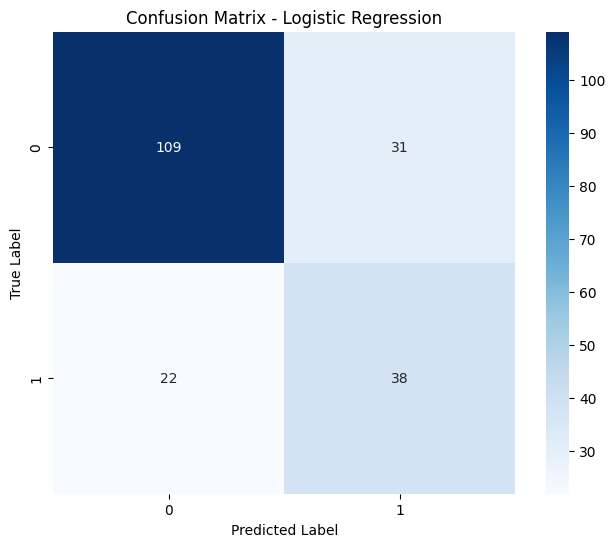

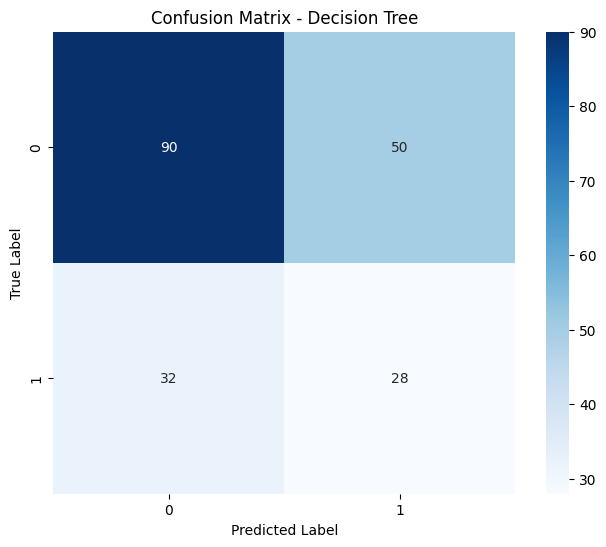

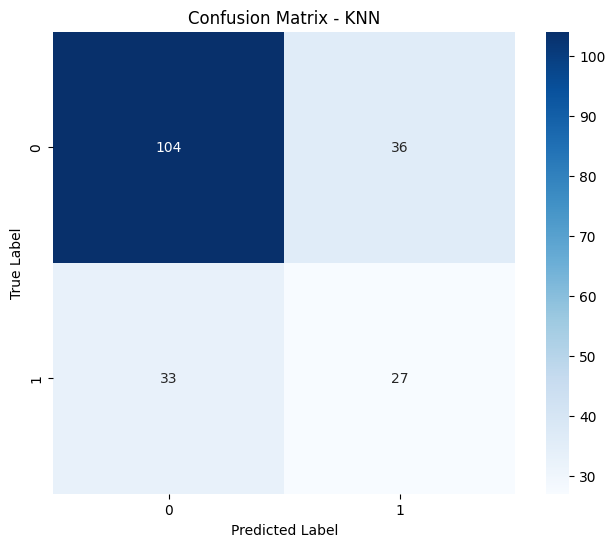

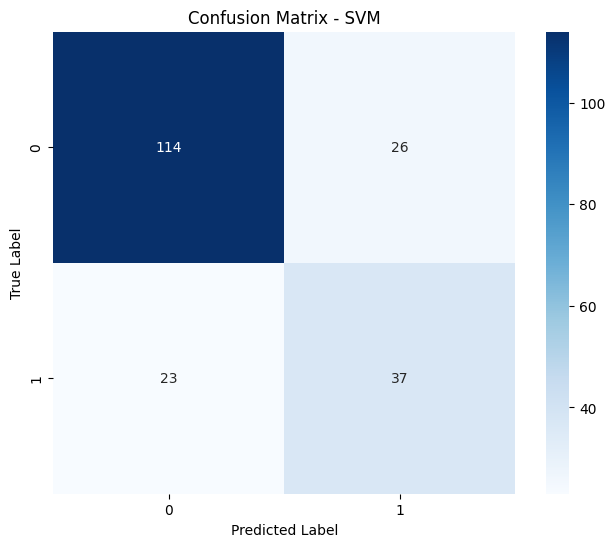

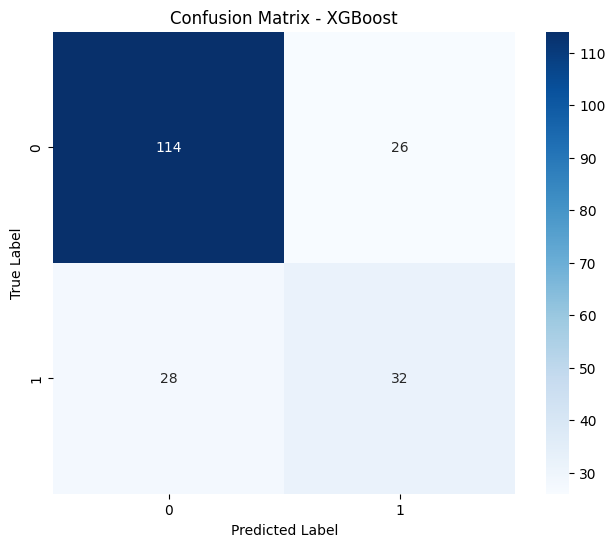

In [37]:
# plot confusion matrix for each model in V3 of notebook
plot_cm(df, 'Target', model_funcs, 1)

## **ROC AUC**

**Comparative ROC AUC is plotted aggregating results in a single figure for visual comparison.**

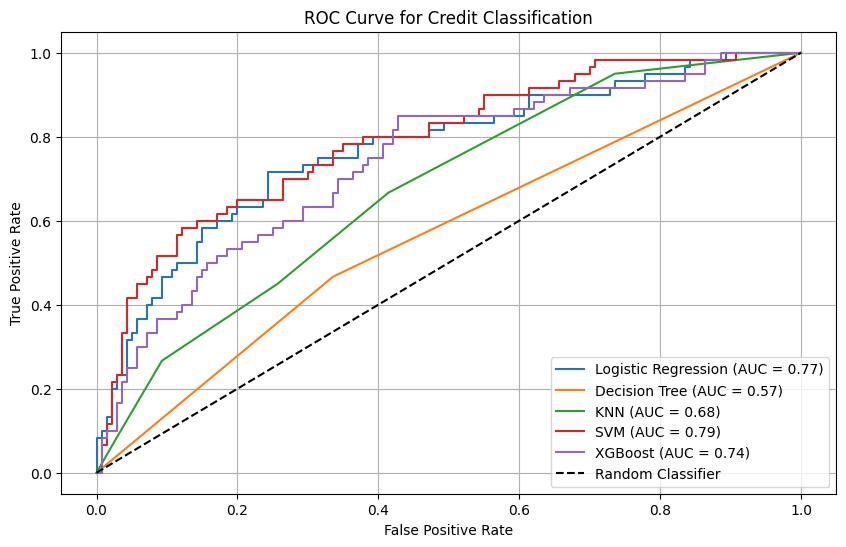

In [38]:
# plot ROC with AUC in legend for V5 Initial Results notebook
auc_list = plot_roc_curve(df, 'Target', model_funcs, 1)